In [4]:
# Initial imports
import pandas as pd
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import sqlite3
from sqlalchemy import create_engine
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
%matplotlib inline

# Tree Visualisation
from sklearn.tree import export_graphviz
import graphviz



## Loading and preprocessing data

In [5]:
# Create SQLite connection
happiness_path = Path('../Resources/HappinessIndexScore.sqlite')
engine = create_engine(f'sqlite:///{happiness_path}')
conn = engine.connect()

In [6]:
# Create df
happiness_df = pd.read_sql('SELECT * FROM final_output', con=engine)

happiness_df.head()

,country,region,ladder_score,logged_GDP_per_capita,social_support,healthy_life_expectancy,freedom_life_choices,generosity,perceptions_corruption,population_density,unemployment_rate,median_age,gini_coefficient,avg_temperature,lt_alcohol_per_capita
0,Finland,Europe,7.804,10.792,0.969,71.150,0.961,-0.019,0.182,16.60,7.16,43.2,27.7,3.24,8.23
1,Denmark,Europe,7.586,10.962,0.954,71.250,0.934,0.134,0.196,138.00,5.14,42.2,27.7,9.77,9.16
2,Iceland,Europe,7.530,10.896,0.983,72.050,0.936,0.211,0.668,3.50,3.56,37.8,26.1,2.11,7.72
3,Israel,Middle East,7.473,10.639,0.943,72.697,0.809,-0.023,0.708,412.24,3.39,30.1,38.6,20.23,3.07
4,Netherlands,Europe,7.403,10.942,0.930,71.550,0.887,0.213,0.379,420.38,3.56,42.2,29.2,11.72,8.23


In [7]:
# Find the mid point of the happiness score
mid_point = (happiness_df['ladder_score'].min()+happiness_df['ladder_score'].max()) * 0.5
mid_point

4.8315

In [8]:
# Create a happiness column with values of 0 or 1 based on the ladder score
happiness_df['happiness'] = 0
happiness_df.loc[happiness_df['ladder_score'] >= mid_point, 'happiness'] = 1

In [9]:
# Drop unnecesary columns
happiness_df.drop(['country', 'region', "ladder_score"], inplace= True, axis= 1)

In [10]:
# Define features set & drop happiness column from X variable
X = happiness_df.copy()
X = happiness_df.drop(columns=['happiness'])


In [11]:
# Define target vector
y = happiness_df["happiness"].ravel()

/var/folders/tg/jpl0p2w93ndfvsd8ln2wc1pw0000gn/T/ipykernel_71462/3803049779.py:2: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  y = happiness_df["happiness"].ravel()


# Split the data into training and testing sets.

In [12]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=98)

In [13]:
# Creating StandardScaler instance
scaler = StandardScaler()

In [14]:
# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

In [15]:
# Scale the training data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

## Fitting the Random Forest Model

In [16]:
# Create the random forest classifier instance
rf_model = RandomForestClassifier(n_estimators=50, max_leaf_nodes=16, random_state=42)


In [17]:
# # Fit the model
rf_model = rf_model.fit(X_train_scaled, y_train)

## Making Predictions Using the Random Forest Model

In [18]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

## Model Evaluation

In [19]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [20]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,5,3
Actual 1,1,16


Accuracy Score : 0.84
Classification Report
              precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.84      0.94      0.89        17

    accuracy                           0.84        25
   macro avg       0.84      0.78      0.80        25
weighted avg       0.84      0.84      0.83        25



In [21]:
# Random Forests in sklearn will automatically calculate feature importance
importances = rf_model.feature_importances_
# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.22439659273203696, 'social_support'),
 (0.18234429797621682, 'logged_GDP_per_capita'),
 (0.14088679171186347, 'healthy_life_expectancy'),
 (0.106161265484144, 'median_age'),
 (0.05827259973483856, 'freedom_life_choices'),
 (0.05192656831609779, 'avg_temperature'),
 (0.04805653141770302, 'gini_coefficient'),
 (0.04634457225934418, 'population_density'),
 (0.04248548625410745, 'lt_alcohol_per_capita'),
 (0.0370281274469126, 'unemployment_rate'),
 (0.03643443400651371, 'generosity'),
 (0.025662732660221475, 'perceptions_corruption')]

In [22]:
# Access the estimators_ attribute after fitting the model
rf = RandomForestClassifier()
estimators = rf_model.estimators_[3].tree_

In [23]:
# Get the number of trees and leaves 
# Source: https://datascience.stackexchange.com/questions/19842/anyway-to-know-all-details-of-trees-grown-using-randomforestclassifier-in-scikit
print("Tree depths: ", [t.get_depth() for t in rf_model.estimators_])
print("Tree number of leaves: ", [t.get_n_leaves() for t in rf_model.estimators_])

Tree depths:  [5, 4, 6, 4, 3, 5, 5, 5, 6, 6, 6, 5, 4, 4, 4, 4, 7, 6, 7, 5, 5, 7, 6, 5, 7, 7, 7, 8, 6, 7, 6, 5, 8, 5, 4, 4, 5, 6, 6, 6, 3, 6, 5, 6, 5, 5, 7, 4, 6, 4]
Tree number of leaves:  [13, 11, 9, 9, 6, 12, 9, 8, 7, 12, 9, 7, 8, 8, 8, 7, 8, 12, 10, 10, 9, 10, 8, 10, 10, 8, 13, 12, 10, 11, 14, 11, 11, 8, 8, 8, 7, 13, 11, 11, 4, 9, 8, 10, 10, 10, 9, 6, 11, 8]


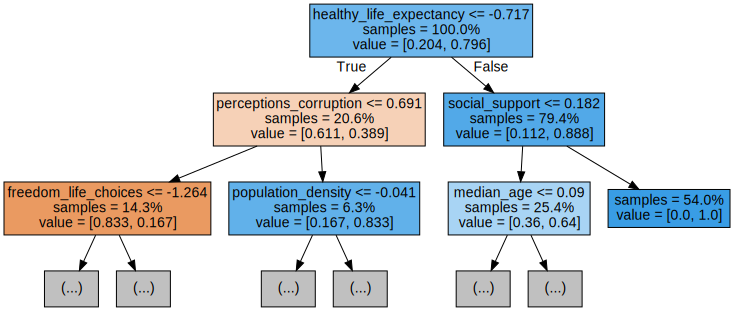

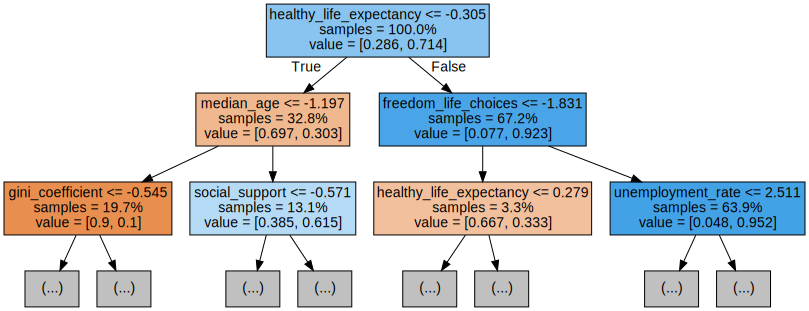

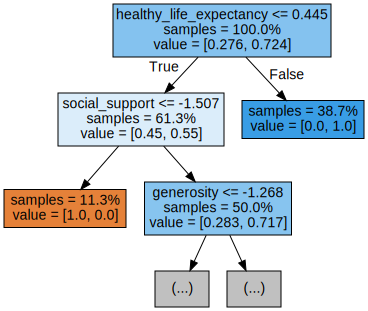

In [24]:
# Export the first three decision trees from the forest
# Source: https://www.datacamp.com/tutorial/random-forests-classifier-python
for i in range(3):
    tree = rf_model.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)